In [1]:
from data_common.notebook import *
import pandas as pd
from uk_ruc.create_la_data import create_la_data, get_la_with_leagues, council_date
from data_common.pandas.df_extensions.space import SpacePDAccessor as SpaceDataFrame

In [2]:
df = create_la_data()

In [3]:
df

,Highly rural,Rural,Urban
local-authority-code,,,
ABC,4.07e-01,1.03e-01,0.49
ABD,4.92e-01,2.12e-01,0.30
ABE,2.46e-03,6.00e-02,0.94
ADU,0.00e+00,0.00e+00,1.00
AGB,4.70e-01,3.52e-01,0.18
...,...,...,...
TVCA,2.85e-02,7.12e-02,0.90
WECA,4.89e-02,3.31e-02,0.92
WMCA,1.17e-03,6.76e-03,0.99


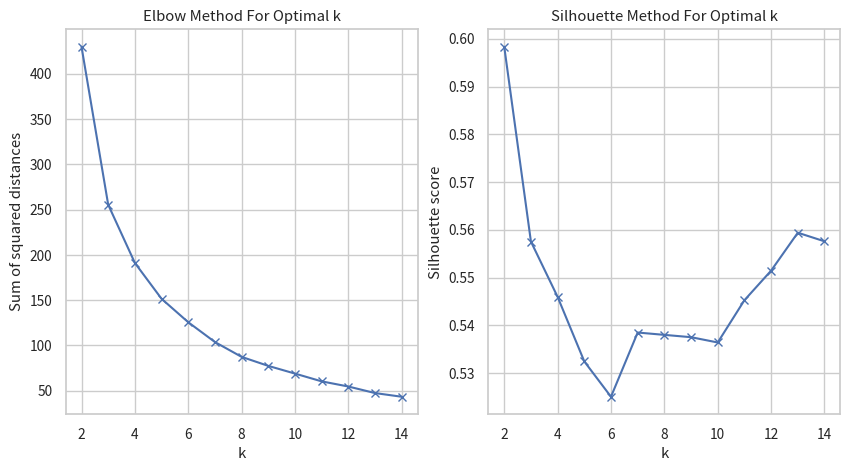

In [4]:
# now look to see if obvious clusters

c = SpaceDataFrame(df).cluster()
c.find_k()

Not *great* clustering behaviour here (to be expected, more of a spectrum). Instead lets work backwards, we want a fairly basic breakdown, so lets pick 4.

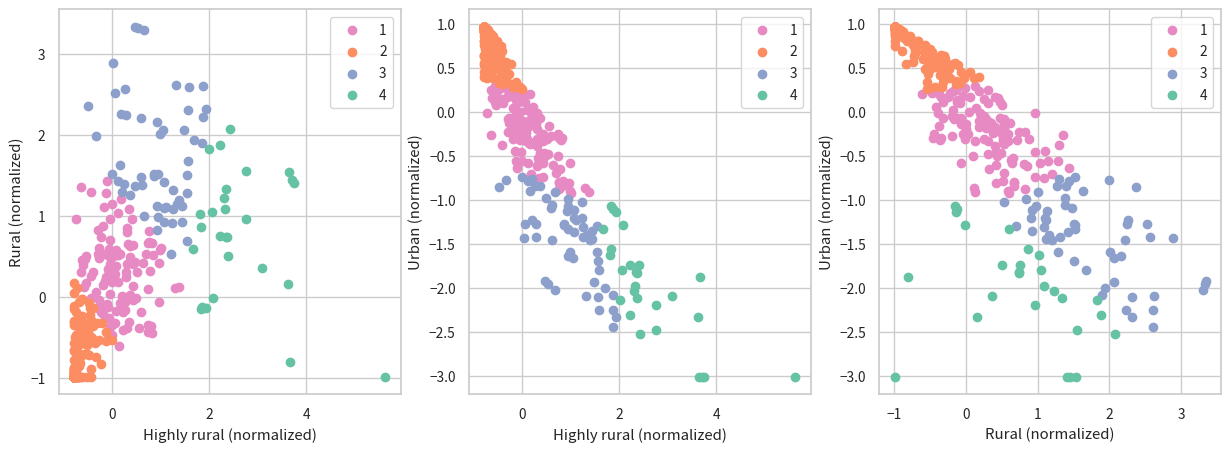

In [5]:
c.set_k(4).plot()

These seem ok grouping (although obviously at the margins the limit is not hard). 

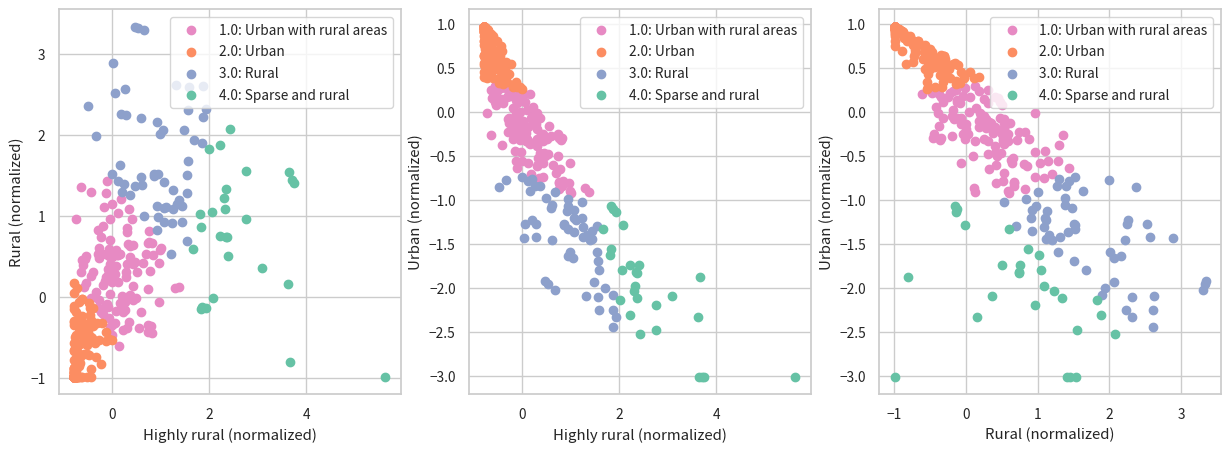

,count,%,random members
labels,,,
1.0: Urban with rural areas,118,29.7,"[WBK, WYR, DBY, SLK, WOR]"
2.0: Urban,197,49.6,"[WND, NTY, SOS, MDW, BDG]"
3.0: Rural,55,13.9,"[ELN, ROH, BOS, TEI, BAB]"
4.0: Sparse and rural,27,6.8,"[CGN, IOS, MUL, ZET, HLD]"


In [6]:
c = (
    c.set_k(4)
    .set_anchor(Path("data", "interim", "ruc_anchor.csv"))
    .add_labels(
        {2: "Urban", 4: "Sparse and rural", 1: "Urban with rural areas", 3: "Rural"}
    )
)
# c.store_anchor(Path("data", "interim", "ruc_anchor.csv"))
c.plot()
c.stats()

Assignment of leagues to groups for basic double check

In [7]:
df["cluster"] = c.label_array(include_short=False)

ldf = get_la_with_leagues().set_index("local-authority-code")
ldf = ldf.join(df, how="outer")

ldf.reset_index().pivot_table(
    "local-authority-code", index="league-group", columns="cluster", aggfunc="count"
).fillna(0)

cluster,Rural,Sparse and rural,Urban,Urban with rural areas
league-group,,,,
Combined/strategic authorities,0.0,0.0,9.0,6.0
County councils,3.0,0.0,2.0,16.0
District councils,35.0,8.0,63.0,58.0
Northern Ireland,0.0,5.0,1.0,5.0
Single tier,17.0,14.0,122.0,33.0


In [8]:
# render out the final copy

df["label"] = c.label_array(include_short=False)
final = df.reset_index()[["local-authority-code", "label"]].rename(
    columns={"label": "ruc-cluster-label"}
)
final = final.la.get_council_info(["official-name"], as_of_date=council_date)

start_columns = ["local-authority-code", "official-name"]
columns = [x for x in final.columns if x not in start_columns]
final = final[start_columns + columns]

final.to_csv(Path("data", "interim", "ruc_cluster.csv"), index=False)